# <center> Задача восстановления регрессии</center>

### Часть 1. Первичный анализ данных c Pandas

В этом заданиии мы будем использовать данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

**[1]. Если у Вас не установлена библиотека Seaborn - выполните в терминале команду *conda install seaborn*. (Seaborn не входит в сборку Anaconda, но эта библиотека предоставляет удобную высокоуровневую функциональность для визуализации данных).**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Считаем данные по росту и весу (*weights_heights.csv*, приложенный в задании) в объект Pandas DataFrame:

In [2]:
data = pd.read_csv('weights_heights.csv', index_col='Index')

In [3]:
df=data

Чаще всего первое, что надо надо сделать после считывания данных - это посмотреть на первые несколько записей. Так можно отловить ошибки чтения данных (например, если вместо 10 столбцов получился один, в названии которого 9 точек с запятой). Также это позволяет познакомиться с данными, как минимум, посмотреть на признаки и их природу (количественный, категориальный и т.д.). 

После этого стоит построить гистограммы распределения признаков - это опять-таки позволяет понять природу признака (степенное у него распределение, или нормальное, или какое-то еще). Также благодаря гистограмме можно найти какие-то значения, сильно не похожие на другие - "выбросы" в данных. 
Гистограммы удобно строить методом *plot* Pandas DataFrame с аргументом *kind='hist'*.

**Пример.** Построим гистограмму распределения роста подростков из выборки *data*. Используем метод *plot* для DataFrame *data* c аргументами *y='Height'* (это тот признак, распределение которого мы строим)

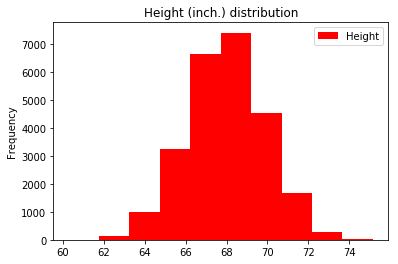

In [4]:
data.plot(y='Height', kind='hist', 
           color='red',  title='Height (inch.) distribution');

Аргументы:

- *y='Height'* - тот признак, распределение которого мы строим
- *kind='hist'* - означает, что строится гистограмма
- *color='red'* - цвет

**[2]. Посмотрите на первые 5 записей с помощью метода *head* Pandas DataFrame. Нарисуйте гистограмму распределения веса с помощью метода *plot* Pandas DataFrame. Сделайте гистограмму зеленой, подпишите картинку.**

In [5]:
df.head()

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


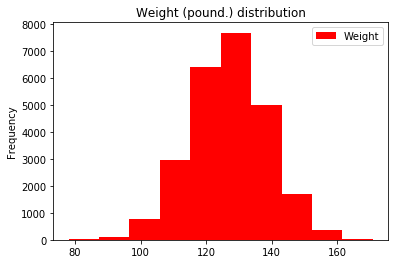

In [6]:
data.plot(y='Weight', kind='hist', 
           color='red',  title='Weight (pound.) distribution');

Один из эффективных методов первичного анализа данных - отображение попарных зависимостей признаков. Создается $m \times m$ графиков (*m* - число признаков), где по диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков. Это можно делать с помощью метода $scatter\_matrix$ Pandas Data Frame или *pairplot* библиотеки Seaborn. 

Чтобы проиллюстрировать этот метод, интересней добавить третий признак. Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)). Для этого воспользуемся удобной связкой метода *apply* Pandas DataFrame и lambda-функций Python.

In [7]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [8]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

**[3]. Постройте картинку, на которой будут отображены попарные зависимости признаков , 'Height', 'Weight' и 'BMI' друг от друга. Используйте метод *pairplot* библиотеки Seaborn.**

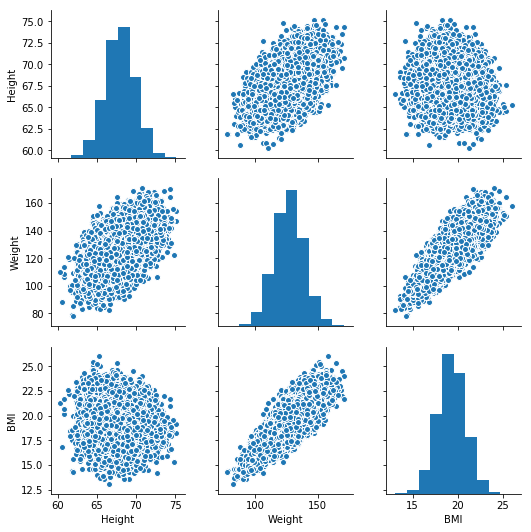

In [9]:
sns.pairplot(df)

Часто при первичном анализе данных надо исследовать зависимость какого-то количественного признака от категориального (скажем, зарплаты от пола сотрудника). В этом помогут "ящики с усами" - boxplots библиотеки Seaborn. Box plot - это компактный способ показать статистики вещественного признака (среднее и квартили) по разным значениям категориального признака. Также помогает отслеживать "выбросы" - наблюдения, в которых значение данного вещественного признака сильно отличается от других. 

**[4]. Создайте в DataFrame *data* новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Постройте «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории. Используйте метод *boxplot* библиотеки Seaborn и метод *apply* Pandas DataFrame. Подпишите ось *y* меткой «Рост», ось *x* – меткой «Весовая категория».**

In [10]:
def weight_category(weight):
    return 1 if weight < 120 else 2 if weight < 150 else 3

data['weight_cat'] = data['Weight'].apply(weight_category)

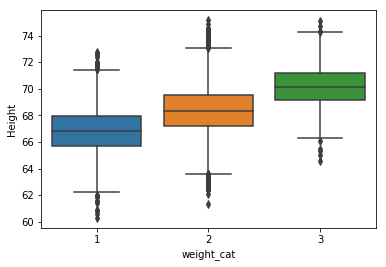

In [11]:
sns.boxplot(x=df['weight_cat'], y=data['Height'])

**[5]. Постройте scatter plot зависимости роста от веса, используя метод *plot* для Pandas DataFrame с аргументом *kind='scatter'*. Подпишите картинку.**

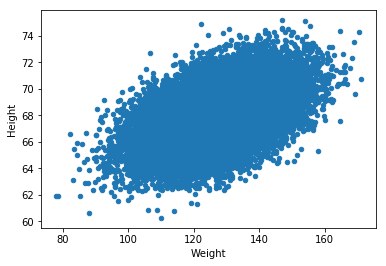

In [12]:
df.plot(x='Weight', y='Height', kind='scatter')

## Часть 2. Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 

**[6]. Напишите функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:**

$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [13]:
def sqErr(x, y, w, b):
    return np.square(np.subtract(np.add(np.multiply(w, x), b), y))

def Q(w, b):
    return np.divide(np.sum(df.apply(lambda r: sqErr(r['Weight'], r['Height'], w, b), axis=1)), len(df))

**[7]. Напишите функцию, которая по итеративно подбирает параметры $w_0$ и $w_1$. 
На каждом шаге обновления параметров сохраняйте среднюю ошибку. 
Нарисуйте график убывания ошибки в зависимости от итерации**

В данном задании удобно будет разделить Ваш код на несколько функций. Одна будет предсказывать рост по весу используя формулу $w_0$ + $w_1$ * $x$, другая -- среднеквадратичную ошибку, третья -- выполнять обновление параметров $w_0$ и $w_1$.

In [14]:
import random

def randTrain(rate):
    global w, b
    qpv = Q(w, b)
    
    pb = b
    pw = w
    
    db = np.multiply(random.random(), rate)
    dw = np.multiply(random.random(), rate)
    
    b += db
    w += dw
    
    qpt = Q(w, b)
    
    if(qpv < qpt):
        b = pb - db
        w = pw - dw
        qpt = Q(w, b)
    return qpt

In [15]:
b = 0
w = 0

def pred(w, b):
    calc = lambda x, y: (np.subtract(np.add(np.multiply(w, x), b), y), x)
    app = df.apply(lambda r: calc(r['Weight'], r['Height']), axis=1)
    return app

def opt_gradb(w, b, prd):
    y = prd.apply(lambda p: p[0])
    return (2/len(y)) * sum(y)

def opt_gradw(w, b, prd):
    app = prd.apply(lambda p: p[0] * p[1])
    return (2/len(app)) * sum(app)

def gradb(w, b):
    calc = lambda x, y: np.subtract(np.add(np.multiply(w, x), b), y)
    app = df.apply(lambda r: calc(r['Weight'], r['Height']), axis=1)
    return np.multiply(np.divide(2, len(app)), np.sum(app))

def gradw(w, b):
    calc = lambda x, y: np.multiply(np.subtract(np.add(np.multiply(w, x), b), y), x)
    app = df.apply(lambda r: calc(r['Weight'], r['Height']), axis=1)
    return np.multiply(np.divide(2, len(app)), np.sum(app))

def train(rate):
    global w, b
    prd = pred(w, b)
    db = np.multiply(-rate, opt_gradb(w, b, prd))
    dw = np.multiply(-rate, opt_gradw(w, b, prd))
    #print(db, dw)
    b += db
    w += dw
    return Q(w, b)


step = 1e-5  
errors = [Q(w, b)]
ws = [w]
bs = [b]
while True:
    errors.append(train(step))
    ws.append(w)
    bs.append(b)
    if np.abs(errors[-2] - errors[-1]) < 1e-4:
        break
print(errors, w, b)

[4626.6797340809171, 2120.081812007712, 980.45784417270556, 462.32815790916101, 226.76065275262638, 119.65995503006039, 70.966651204365078, 48.828250781074566, 38.763028900148271, 34.186873874672294, 32.106321381527941, 31.160393800667283, 30.730323081986583, 30.534786524664717, 30.445880850592729, 30.405454874305352, 30.387070177483793, 30.378706541492456, 30.374898977680992, 30.373162830665613, 30.372368452651607, 30.372002249621787, 30.371830716216522, 30.371747689296956] 0.531166365561 0.00436600227687


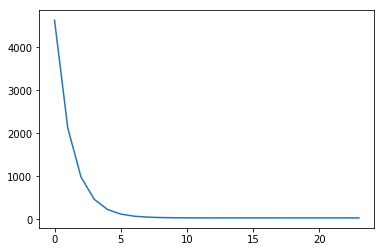

In [16]:
plt.plot(errors)

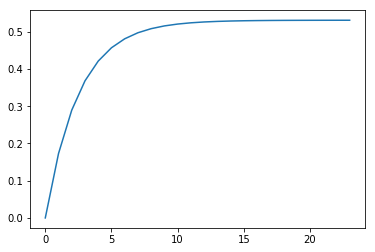

In [17]:
plt.plot(ws)

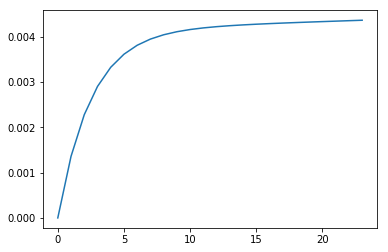

In [18]:
plt.plot(bs)

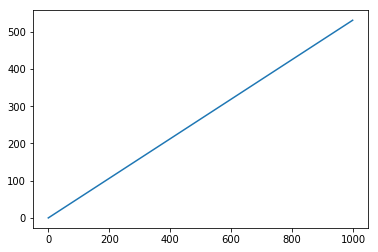

In [19]:
plt.plot(range(1000), [w * x + b for x in range(1000)])